In [1]:
import glob

import heartpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Ellipse
from scipy import interpolate, signal
from scipy.integrate import trapz
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from scipy.stats import zscore
from tqdm.notebook import tqdm

print(pd.__version__)

2.0.0


In [2]:
def timedomain(rr):
    results = {}

    hr = 60000 / rr

    # HRV metrics
    results["Mean RR (ms)"] = np.mean(rr)
    results["STD RR/SDNN (ms)"] = np.std(rr)
    results["Mean HR (Kubios' style) (beats/min)"] = 60000 / np.mean(rr)
    results["Mean HR (beats/min)"] = np.mean(hr)
    results["STD HR (beats/min)"] = np.std(hr)
    results["Max HR (beats/min)"] = np.max(hr)
    results["RMSSD (ms)"] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results["NNxx"] = np.sum((np.abs(np.diff(rr)) > 20) * 1)
    results["pNNxx (%)"] = 100 * np.sum((np.abs(np.diff(rr)) > 20) * 1) / len(rr)
    return results


def frequency_domain(rri, fs, nperseg=256):
    # Estimate the spectral density using Welch's method
    fxx, pxx = signal.welch(x=rri, fs=fs)

    """
    Segement found frequencies in the bands 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    """
    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)

    # calculate power in each band by integrating the spectral density
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])

    # sum these up to get total power
    total_power = vlf + lf + hf

    # find which frequency has the most power in each band
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    # fraction of lf and hf
    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)

    results = {}
    results["Power VLF (ms2)"] = vlf
    results["Power LF (ms2)"] = lf
    results["Power HF (ms2)"] = hf
    results["Power Total (ms2)"] = total_power

    results["LF/HF"] = lf / hf
    results["Peak VLF (Hz)"] = peak_vlf
    results["Peak LF (Hz)"] = peak_lf
    results["Peak HF (Hz)"] = peak_hf

    results["Fraction LF (nu)"] = lf_nu
    results["Fraction HF (nu)"] = hf_nu
    return results


def plot_poincare(rr):
    rr_n = rr[:-1]
    rr_n1 = rr[1:]

    sd1 = np.sqrt(0.5) * np.std(rr_n1 - rr_n)
    sd2 = np.sqrt(0.5) * np.std(rr_n1 + rr_n)

    m = np.mean(rr)
    min_rr = np.min(rr)
    max_rr = np.max(rr)

    plt.figure(figsize=(10, 10))
    plt.title("Poincare plot")

    sns.scatterplot(x=rr_n, y=rr_n1, color="#51A6D8")

    plt.xlabel(r"$RR_n (ms)$")
    plt.ylabel(r"$RR_{n+1} (ms)$")

    e1 = Ellipse(
        (m, m), 2 * sd1, 2 * sd2, angle=-45, linewidth=1.2, fill=False, color="k"
    )
    plt.gca().add_patch(e1)

    plt.arrow(
        m,
        m,
        (max_rr - min_rr) * 0.4,
        (max_rr - min_rr) * 0.4,
        color="k",
        linewidth=0.8,
        head_width=3,
        head_length=3,
    )
    plt.arrow(
        m,
        m,
        (min_rr - max_rr) * 0.4,
        (max_rr - min_rr) * 0.4,
        color="k",
        linewidth=0.8,
        head_width=3,
        head_length=3,
    )

    plt.arrow(m, m, sd2 * np.sqrt(0.5), sd2 * np.sqrt(0.5), color="green", linewidth=5)
    plt.arrow(m, m, -sd1 * np.sqrt(0.5), sd1 * np.sqrt(0.5), color="red", linewidth=5)

    plt.text(max_rr, max_rr, "SD2", fontsize=15, color="green")
    plt.text(m - (max_rr - min_rr) * 0.4 - 20, max_rr, "SD1", fontsize=15, color="red")

    return sd1, sd2

In [3]:
path = "./1_e07e0563-63d7-4ab2-8fea-4e2df9fc257b-4/garmin-device-bbi/"

df = pd.DataFrame()

# search all files inside a specific folder
# *.* means file name with any extension

for file in tqdm(glob.glob(f"{path}*")):
    skiprows = pd.read_csv(file, sep=",", nrows=1, header=None)[1][0]

    df = pd.concat(
        [
            df,
            pd.read_csv(
                file,
                sep=",",
                skiprows=skiprows,
            ),
        ]
    )


df = df.sort_values("isoDate")

  0%|          | 0/15 [00:00<?, ?it/s]

In [4]:
%%time
df["bbi_diff"] = df["bbi"].diff().shift(-1)
df["sq_bbi_diff"] = df["bbi_diff"] ** 2

df["isoDate"] = pd.to_datetime(df["isoDate"])

CPU times: user 14.9 s, sys: 299 ms, total: 15.2 s
Wall time: 15.2 s


In [5]:
df

,timezone,unixTimestampInMs,isoDate,deviceType,bbi,bbi_diff,sq_bbi_diff
0,Europe/Copenhagen,1675960837000,2023-02-09 18:40:37+02:00,garmin_Vivosmart5,958,-7.0,49.0
1,Europe/Copenhagen,1675960837958,2023-02-09 18:40:37.958000+02:00,garmin_Vivosmart5,951,-32.0,1024.0
2,Europe/Copenhagen,1675960839868,2023-02-09 18:40:39.868000+02:00,garmin_Vivosmart5,919,-6.0,36.0
3,Europe/Copenhagen,1675960840787,2023-02-09 18:40:40.787000+02:00,garmin_Vivosmart5,913,18.0,324.0
4,Europe/Copenhagen,1675960841700,2023-02-09 18:40:41.700000+02:00,garmin_Vivosmart5,931,15.0,225.0
...,...,...,...,...,...,...,...
23490,Europe/Copenhagen,1679609695876,2023-03-24 00:14:55.876000+02:00,garmin_Vivosmart5,1094,-150.0,22500.0
23491,Europe/Copenhagen,1679609696971,2023-03-24 00:14:56.971000+02:00,garmin_Vivosmart5,944,-74.0,5476.0
23492,Europe/Copenhagen,1679609697679,2023-03-24 00:14:57.679000+02:00,garmin_Vivosmart5,870,227.0,51529.0
23493,Europe/Copenhagen,1679609698550,2023-03-24 00:14:58.550000+02:00,garmin_Vivosmart5,1097,-20.0,400.0


In [6]:
df["bbi_diff"].describe()

count    3.523494e+06
mean     3.377329e-05
std      3.763795e+01
min     -7.900000e+02
25%     -1.400000e+01
50%      0.000000e+00
75%      1.400000e+01
max      7.200000e+02
Name: bbi_diff, dtype: float64

In [7]:
def convert_to_HR(x):
    return 60000 / x

In [8]:
df.groupby(pd.Grouper(key="isoDate", freq="300s"))["bbi"].mean().describe()

count    11043.000000
mean       923.585770
std        158.817318
min        375.371812
25%        833.772918
50%        950.557377
75%       1049.286091
max       1349.869048
Name: bbi, dtype: float64

In [9]:
df.groupby(pd.Grouper(key="isoDate", freq="300s"))["bbi"].mean().apply(
    convert_to_HR
).min()

44.44875605217437

<Axes: xlabel='isoDate'>

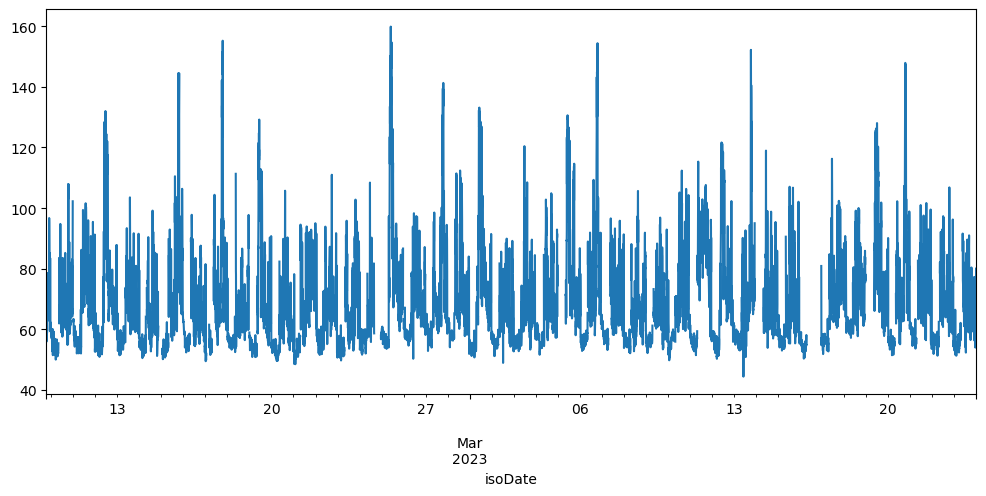

In [10]:
df.groupby(pd.Grouper(key="isoDate", freq="300s"))["bbi"].mean().apply(
    convert_to_HR
).plot(figsize=(12, 5))

In [11]:
rr_ecg = df[
    df["isoDate"].between("2023-02-18 03:00:00+01:00", "2023-02-18 03:05:00+01:00")
]["bbi"].to_numpy()

In [12]:
timedomain(rr_ecg)

{'Mean RR (ms)': 1062.6014234875445,
 'STD RR/SDNN (ms)': 20.895891696422762,
 "Mean HR (Kubios' style) (beats/min)": 56.46519821427973,
 'Mean HR (beats/min)': 56.48696061445848,
 'STD HR (beats/min)': 1.1085126833303165,
 'Max HR (beats/min)': 63.02521008403362,
 'RMSSD (ms)': 27.509933270937402,
 'NNxx': 99,
 'pNNxx (%)': 35.23131672597865}

In [13]:
x_ecg = np.cumsum(rr_ecg) / 1000

# fit function to the dataset
f_ecg = interp1d(x_ecg, rr_ecg, kind="cubic", fill_value="extrapolate")

# sample rate for interpolation
fs = 4
steps = 1 / fs

# sample using the interpolation function
xx_ecg = np.arange(0, np.max(x_ecg), steps)
rr_interpolated_ecg = f_ecg(xx_ecg)

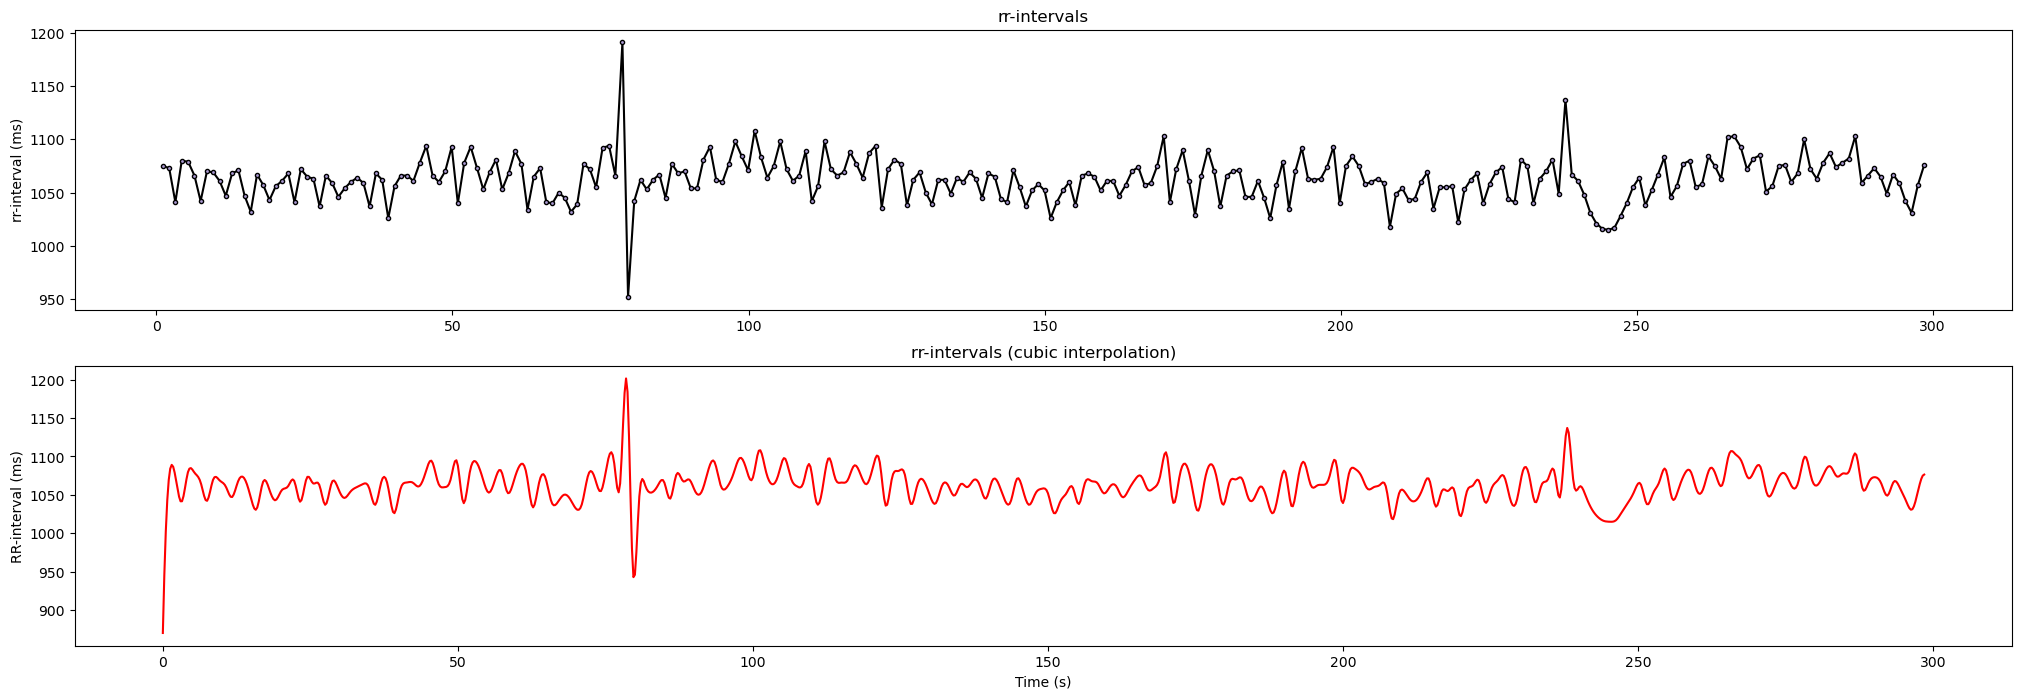

In [14]:
plt.figure(figsize=(25, 8))

plt.subplot(211)
plt.title("rr-intervals")
plt.plot(x_ecg, rr_ecg, color="k", markerfacecolor="#A999D1", marker="o", markersize=3)
plt.ylabel("rr-interval (ms)")

plt.subplot(212)
plt.title("rr-intervals (cubic interpolation)")
plt.plot(xx_ecg, rr_interpolated_ecg, color="r")
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (ms)")

plt.show()

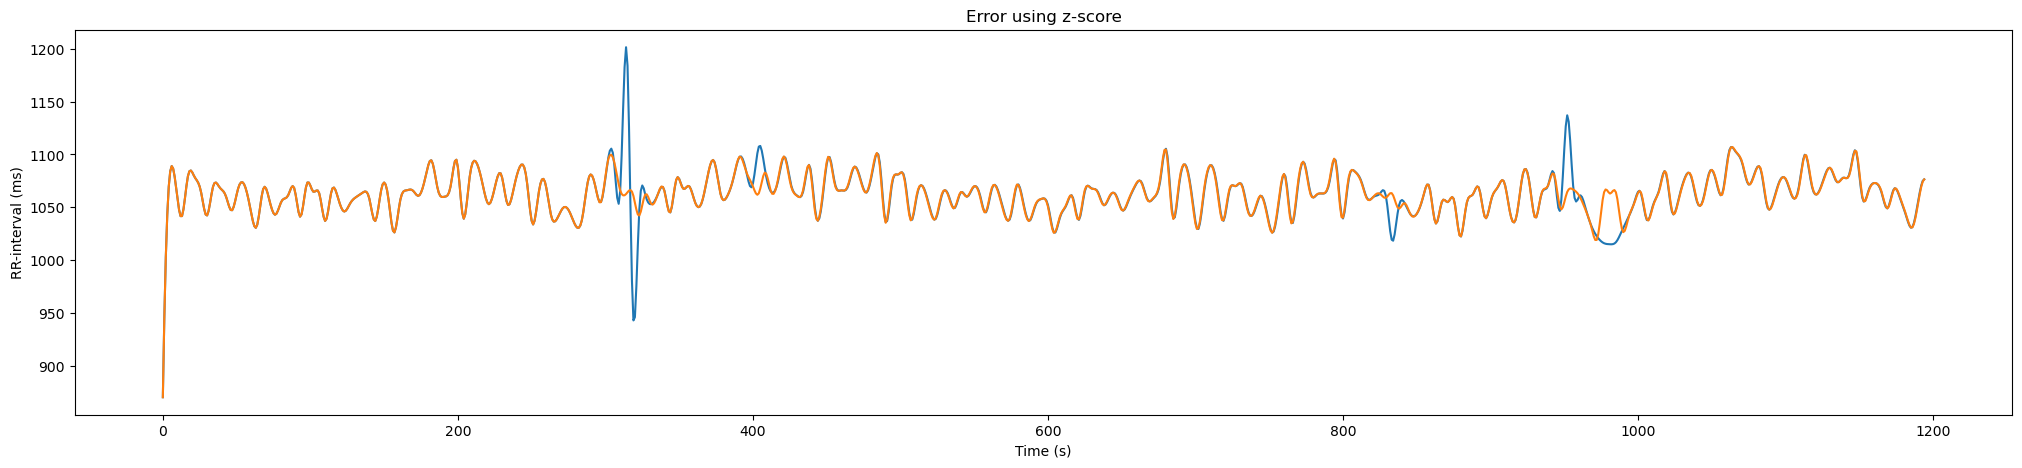

In [15]:
# we have a few false peak detections, lets replace them with the data medium
rr_ecg[np.abs(zscore(rr_ecg)) > 2] = np.median(rr_ecg)

x_ecg = np.cumsum(rr_ecg) / 1000
f_ecg = interp1d(x_ecg, rr_ecg, kind="cubic", fill_value="extrapolate")

xx_ecg = np.arange(0, np.max(x_ecg), steps)
clean_rr_interpolated_ecg = f_ecg(xx_ecg)

plt.figure(figsize=(25, 5))
plt.title("Error using z-score")
plt.plot(rr_interpolated_ecg)
plt.plot(clean_rr_interpolated_ecg)
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (ms)")
plt.show()

In [16]:
timedomain(rr_ecg)

{'Mean RR (ms)': 1062.779359430605,
 'STD RR/SDNN (ms)': 16.646451353071292,
 "Mean HR (Kubios' style) (beats/min)": 56.45574452268778,
 'Mean HR (beats/min)': 56.46960306560476,
 'STD HR (beats/min)': 0.8849874502564249,
 'Max HR (beats/min)': 58.765915768854065,
 'RMSSD (ms)': 20.52463676379473,
 'NNxx': 93,
 'pNNxx (%)': 33.096085409252666}

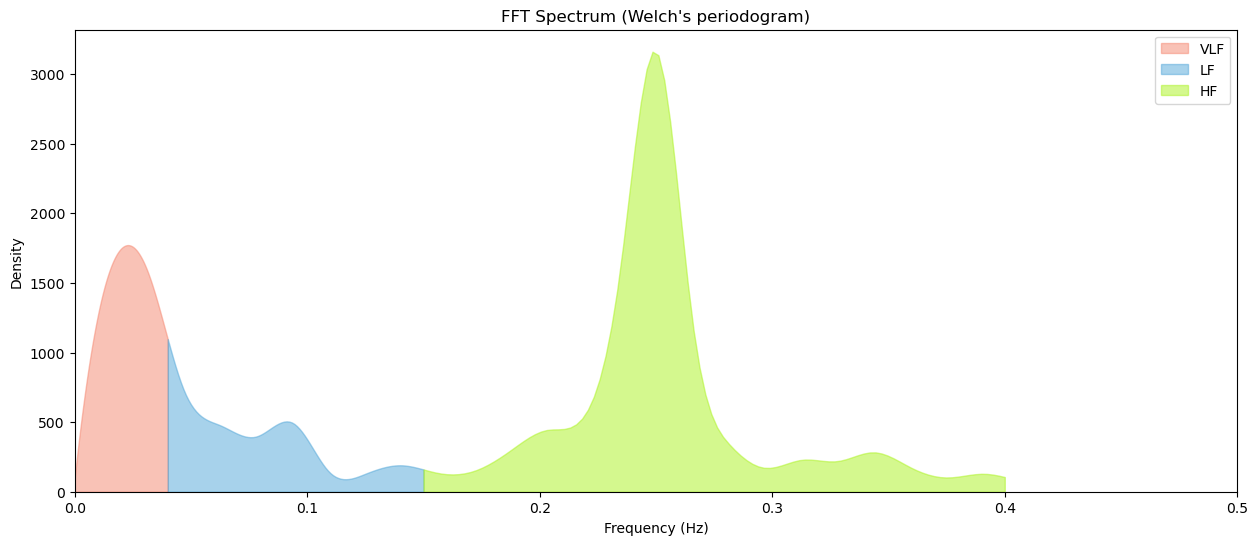

In [17]:
fxx, pxx = signal.welch(x=clean_rr_interpolated_ecg, fs=fs, nperseg=256)

# fit a function for plotting bands
powerspectrum_f = interp1d(fxx, pxx, kind="cubic", fill_value="extrapolate")

plt.figure(figsize=(15, 6))
# plt.plot(fxx,pxx,color='k',linewidth=0.5)
plt.title("FFT Spectrum (Welch's periodogram)")

# setup frequency bands for plotting
x_VLF = np.linspace(0, 0.04, 100)
x_LF = np.linspace(0.04, 0.15, 100)
x_HF = np.linspace(0.15, 0.4, 100)

plt.gca().fill_between(
    x_VLF, powerspectrum_f(x_VLF), alpha=0.5, color="#F5866F", label="VLF"
)
plt.gca().fill_between(
    x_LF, powerspectrum_f(x_LF), alpha=0.5, color="#51A6D8", label="LF"
)
plt.gca().fill_between(
    x_HF, powerspectrum_f(x_HF), alpha=0.5, color="#ABF31F", label="HF"
)

plt.gca().set_xlim(0, 0.5)
plt.gca().set_ylim(0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Density")

plt.legend()
plt.show()

In [18]:
frequency_domain(clean_rr_interpolated_ecg, fs=fs)

{'Power VLF (ms2)': 38.51485116191178,
 'Power LF (ms2)': 32.83849643716158,
 'Power HF (ms2)': 141.46785293063203,
 'Power Total (ms2)': 212.82120052970538,
 'LF/HF': 0.23212691616422393,
 'Peak VLF (Hz)': 0.015625,
 'Peak LF (Hz)': 0.046875,
 'Peak HF (Hz)': 0.25,
 'Fraction LF (nu)': 18.83952968796965,
 'Fraction HF (nu)': 81.16047031203034}

In [19]:
rr_ecg[np.abs(zscore(rr_ecg)) > 3] = np.median(rr_ecg)

(14.513109617353068, 18.557906993780197)

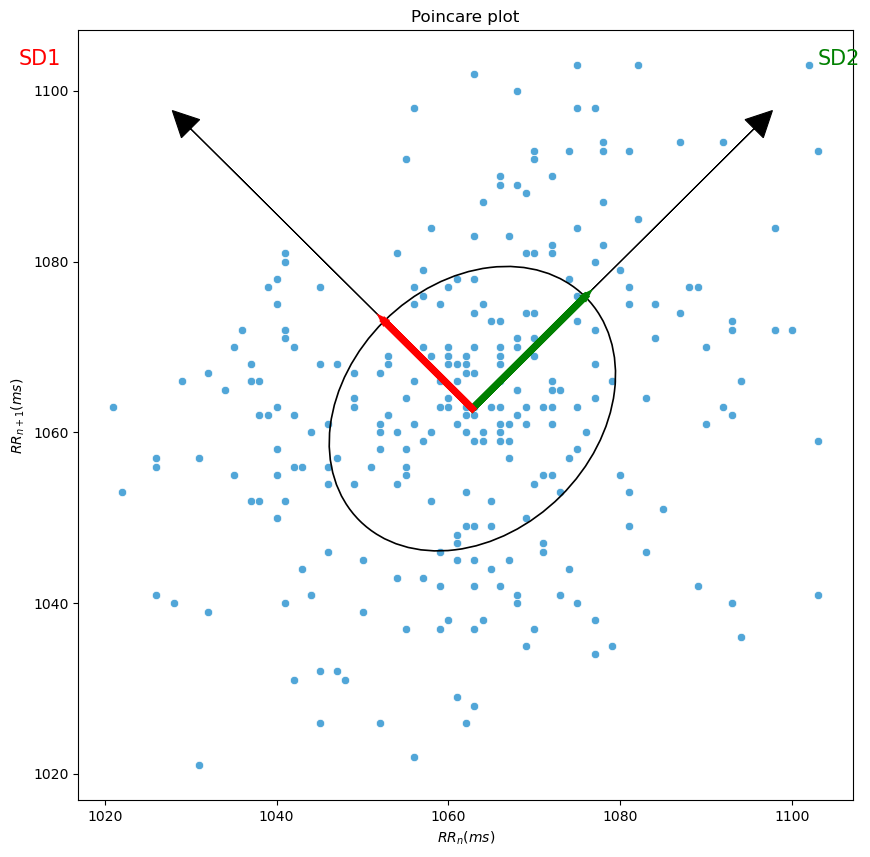

In [20]:
plot_poincare(rr_ecg)

In [21]:
# Plot HHR in 5 min intervals:


def calc_HRV(bbi_series):
    if bbi_series.shape[0] > 50:
        rr_ecg = bbi_series.to_numpy()
        rr_ecg[np.abs(zscore(rr_ecg)) > 3] = np.median(rr_ecg)

        return timedomain(rr_ecg)["RMSSD (ms)"]
    else:
        return None

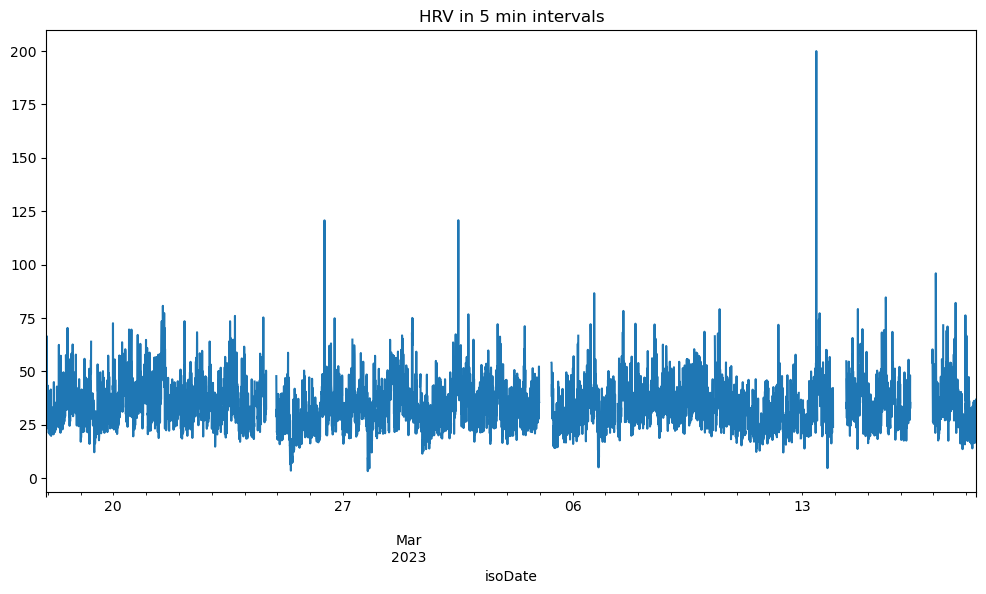

In [22]:
res = (
    df[df["isoDate"].between("2023-02-17 22:00:00+01:00", "2023-03-18 06:30:00+01:00")]
    .groupby(pd.Grouper(key="isoDate", freq="300s"))["bbi"]
    .apply(calc_HRV)
)

res.plot(figsize=(12, 6), title="HRV in 5 min intervals");
# plt.ylim(ymin=0)

<Axes: xlabel='isoDate'>

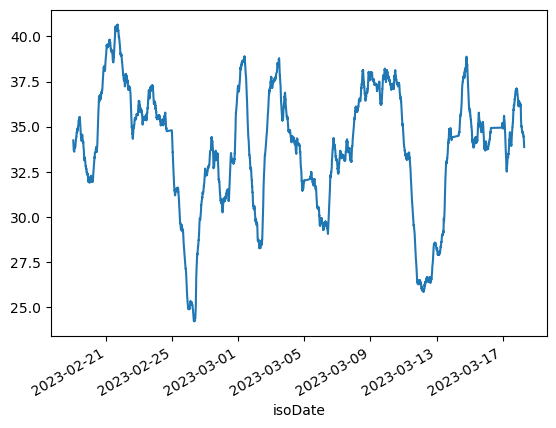

In [23]:
res.dropna().rolling(288).mean().plot()

<Axes: title={'center': 'HR in 5 min intervals'}, xlabel='isoDate'>

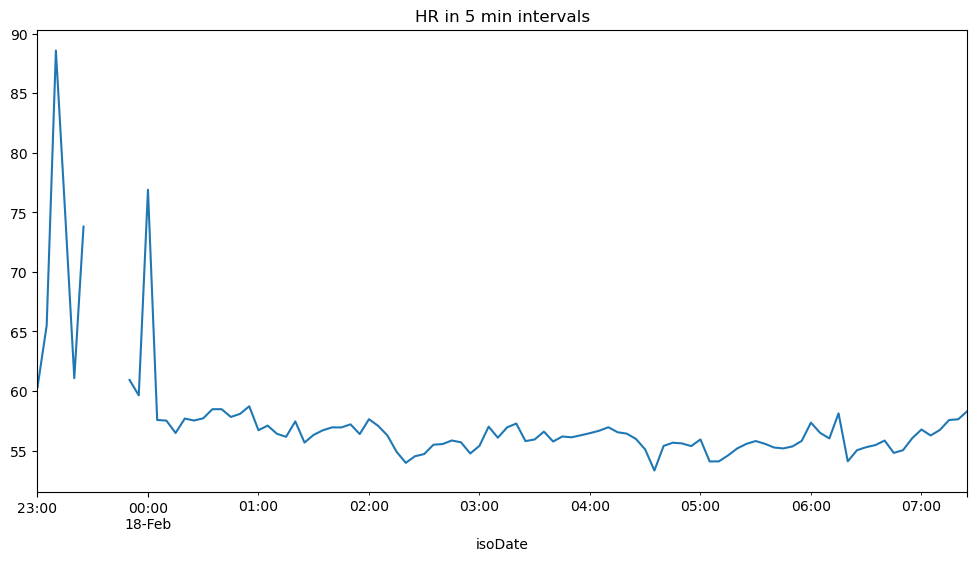

In [24]:
df[
    df["isoDate"].between("2023-02-17 22:00:00+01:00", "2023-02-18 06:30:00+01:00")
].groupby(pd.Grouper(key="isoDate", freq="300s"))["bbi"].mean().apply(
    convert_to_HR
).plot(
    figsize=(12, 6), title="HR in 5 min intervals"
)
# plt.ylim(ymin=0)

---
### Python Heart Rate Analysis Toolkit
https://python-heart-rate-analysis-toolkit.readthedocs.io/en/latest/index.html

In [25]:
hp.analysis.calc_breathing

<function heartpy.analysis.calc_breathing(rrlist, method='welch', filter_breathing=True, bw_cutoff=[0.1, 0.4], measures={}, working_data={})>

In [26]:
peaklist = (
    df[df["isoDate"].between("2023-02-10 03:00:00+01:00", "2023-02-10 03:05:00+01:00")][
        "bbi"
    ]
    .cumsum()
    .to_numpy()
)

In [27]:
wd = hp.analysis.calc_rr(peaklist, sample_rate=1000.0)

In [28]:
m, wd = hp.analysis.calc_breathing(wd["RR_list"])

In [29]:
m

{'breathingrate': 0.26666666666666666}

In [30]:
60 / (1 / m["breathingrate"])

16.0

---